# Pytorch Tutorial for Satellite

Pytorch is a popular deep learning framework and it's easy to get started for SAT.

In [50]:
# Import Library
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
# Parameters Setting
BATCH_SIZE = 128
NUM_EPOCHS = 10
input_size = 64

euro_mean, euro_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]   # 0-255 归一 0-1

device = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

In [52]:
# download and load the data
from torch.utils.data import random_split, DataLoader

dataset = ImageFolder(root='/users/sunyong/dataserver/EuroSAT2750/', transform=transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = euro_mean,std = euro_std),
]))
train_set, val_set = random_split(dataset, [21600,5400]) 

# encapsulate them into dataloader form
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [53]:
# Fixed input for debugging
# fixed_x = next(iter(train_loader))
# fixed_x = fixed_x[0]
# image_channels = fixed_x.size(1)
# img_dim = fixed_x.size(-1)
# fixed_x.shape, image_channels, img_dim

In [54]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = euro_std * inp + euro_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

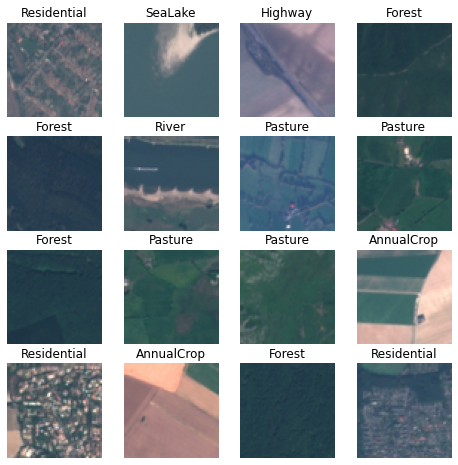

In [55]:
n = 4
inputs, classes = next(iter(train_loader))  # 
fig, axes = plt.subplots(n, n, figsize=(8, 8))
class_names = dataset.classes
num_classes = len(class_names)

for i in range(n):
    for j in range(n):
        image = inputs[i * n + j].numpy().transpose((1, 2, 0))   # 3 * 64 * 64 === PIL.image: 64*64*3
        image = np.clip(np.array(euro_std) * image + np.array(euro_mean), 0, 1)
        title = class_names[classes[i * n + j]]
        axes[i, j].imshow(image)
        axes[i, j].set_title(title)
        axes[i, j].axis('off')

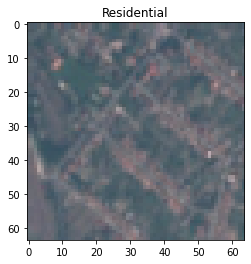

In [56]:
imshow(inputs[0], class_names[classes[0]])

### Exploratory Data Analysis
* Next, let's explore our dataset a little bit more. In particular, how many images of each class are included

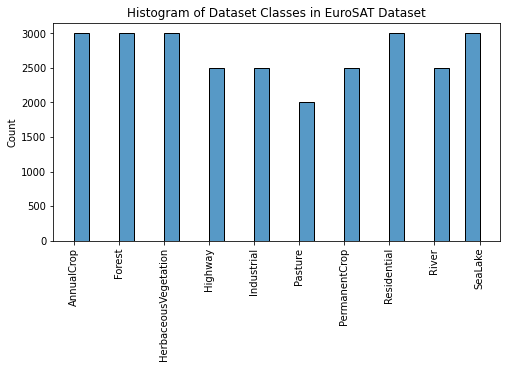

In [57]:
plt.figure(figsize=(8, 4))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

In [58]:
# model = nn.Sequential()
# model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
# model.add_module('relu1', nn.ReLU())
# model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
# model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
# model.add_module('relu2', nn.ReLU())        
# model.add_module('pool2', nn.MaxPool2d(kernel_size=2))    

In [65]:
class ConvSAT(nn.Module):
    def __init__(self) -> None:
        super(ConvSAT, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*16*16, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
        
    def calculate_shape(self, input_size=64):
        tmp = torch.randn(2, 3, input_size, input_size).to(device)
        out = self.layer1(tmp)
        out = self.layer2(out)
        print('conv out:', out.shape)


In [66]:
model = ConvSAT().to(device)
model.calculate_shape()

conv out: torch.Size([2, 32, 16, 16])


In [67]:
def train_conv_net(model, train_loader, num_epochs=10, learning_rate=0.001):
    # Loss and optimizer
    total_step = len(train_loader)
    criterion = torch.nn.CrossEntropyLoss()   # 不需要softmax
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # print(images.shape)
            
            # Forward pass
            outputs = model(images)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [68]:
train_conv_net(model, train_loader)

Epoch [1/10], Step [100/168], Loss: 0.8858
Epoch [2/10], Step [100/168], Loss: 0.4988
Epoch [3/10], Step [100/168], Loss: 0.6344
Epoch [4/10], Step [100/168], Loss: 0.4292
Epoch [5/10], Step [100/168], Loss: 0.4324
Epoch [6/10], Step [100/168], Loss: 0.2275
Epoch [7/10], Step [100/168], Loss: 0.2259
Epoch [8/10], Step [100/168], Loss: 0.3019
Epoch [9/10], Step [100/168], Loss: 0.3731
Epoch [10/10], Step [100/168], Loss: 0.3147
